# 1 - Google Play Store Apps Data
This dataset consists of web scraped data of more than 10,000 Google Play Store apps and 60,000 app reviews. `apps_data.csv` consists of data about the apps such as category, number of installs, and price. `review_data.csv` holds reviews of the apps, including the text of the review and sentiment scores. You can join the two tables on the `App` column.

Not sure where to begin? Scroll to the bottom to find challenges!

## Import libs and datasets

In [1]:
# Standard libs
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [2]:
gps = pd.read_csv("googleplaystore.csv")

In [3]:
reviews = pd.read_csv('googleplaystore_user_reviews.csv')

## Data Dictionary

**data_apps.csv**

| variable       | class     | description                                                                  |
|:---------------|:----------|:-----------------------------------------------------------------------------|
| App            | character | The application name                                                         |
| Category       | character | The category the app belongs to                                              |
| Rating         | numeric   | Overall user rating of the app                                               |
| Reviews        | numeric   | Number of user reviews for the app                                           |
| Size           | character | The size of the app                                                          |
| Installs       | character | Number of user installs for the app                                          |
| Type           | character | Either "Paid" or "Free"                                                      |
| Price          | character | Price of the app                                                             |
| Content Rating | character | The age group the app is targeted at - "Children" / "Mature 21+" / "Adult"   |
| Genres         | character | Possibly multiple genres the app belongs to                                  |
| Last Updated   | character | The date the app was last updated                                            |
| Current Ver    | character | The current version of the app                                               |
| Android Ver    | character | The Android version needed for this app                                      |

**data_reviews.csv**

| variable               | class        | description                                           |
|:-----------------------|:-------------|:------------------------------------------------------|
| App                    | character    | The application name                                  |
| Translated_Review      | character    | User review (translated to English)                   |
| Sentiment              | character    | The sentiment of the user - Positive/Negative/Neutral |
| Sentiment_Polarity     | character    | The sentiment polarity score                          |
## | Sentiment_Subjectivity | character    | The sentiment subjectivity score                      |

## Source of dataset

[Source](https://www.kaggle.com/lava18/google-play-store-apps) of dataset.

Create data_info function

In [4]:
# Creating data_info function
def data_info(df):
    temp=pd.DataFrame(index=df.columns)
    temp['total']=[df[i].shape[0] for i in df.columns]
    temp['dtype']=df.dtypes
    temp['#distinct']=[df[i].nunique() for i in df.columns]
    temp['%distinct']=['{:.2f}'.format(df[i].nunique()/df.shape[0]) for i in df.columns]
    temp['#null']=df.isna().sum()
    temp['#zero']=[sum(df[i]=='0') for i in df.columns]
    temp['#negative']=[sum(1 for j in df[i] if j<0) if type(df[i].dtypes) in [float,int,complex] else '-' for i in df.columns]
    temp['#empty']=[sum(df[i]=='') for i in df.columns]
    temp['(%)null']=['{:.2f}'.format(num1) if num1 != 0 else '-' for num1 in temp['#null']*100/temp['total']]
    temp['(%)zero']=['{:.2f}'.format(num2) if num2 != 0 else '-' for num2 in temp['#zero']*100/temp['total']]
    temp['(%)negative']=['{:.2f}'.format(num3) if num3 != 0 else '-' for num3 in temp['#empty']*100/temp['total']]
    temp['(%)empty']=['{:.2f}'.format(num4) if num4 != 0 else '-' for num4 in
    temp['#empty']*100/temp['total']]
    return temp

# **2 - Initial Data Preparation**

## Create Game Datasets

In [5]:
# Create a dataset: gps_games
gps_games = gps[gps['Category']=='GAME']

In [6]:
# List of games
games_list = gps_games['App'].unique()

In [7]:
# Create a dataset: game_reviews
game_reviews = reviews[reviews['App'].isin(games_list)]

## Data Cleaning

### gps_games

In [8]:
data_info(gps_games)

,total,dtype,#distinct,%distinct,#null,#zero,#negative,#empty,(%)null,(%)zero,(%)negative,(%)empty
App,1144,object,960,0.84,0,0,-,0,-,-,-,-
Category,1144,object,1,0.00,0,0,-,0,-,-,-,-
Rating,1144,float64,28,0.02,47,0,-,0,4.11,-,-,-
Reviews,1144,object,1038,0.91,0,12,-,0,-,1.05,-,-
Size,1144,object,151,0.13,0,0,-,0,-,-,-,-
Installs,1144,object,19,0.02,0,0,-,0,-,-,-,-
Type,1144,object,2,0.00,0,0,-,0,-,-,-,-
Price,1144,object,18,0.02,0,1061,-,0,-,92.74,-,-
Content Rating,1144,object,4,0.00,0,0,-,0,-,-,-,-
Genres,1144,object,24,0.02,0,0,-,0,-,-,-,-


In [9]:
gps_games.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1653,ROBLOX,GAME,4.5,4447388,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
1654,Subway Surfers,GAME,4.5,27722264,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up
1655,Candy Crush Saga,GAME,4.4,22426677,74M,"500,000,000+",Free,0,Everyone,Casual,"July 5, 2018",1.129.0.2,4.1 and up
1656,Solitaire,GAME,4.7,254258,23M,"10,000,000+",Free,0,Everyone,Card,"August 1, 2018",2.137.0,4.1 and up
1657,Bubble Shooter,GAME,4.5,148897,46M,"10,000,000+",Free,0,Everyone,Casual,"July 17, 2018",1.20.1,4.0.3 and up


**1. Rating**

In [10]:
# Number of null
gps_games['Rating'].isna().sum()

47

**1. Review:**

In [11]:
# Convert to integer
gps_games['Reviews'] = gps_games['Reviews'].astype(int)

# Mapping num of reviews of duplicates with mean of reviews
mean_reviews = gps_games.groupby('App')['Reviews'].mean().to_dict()
gps_games['Reviews'] = gps_games['App'].map(mean_reviews)

<ipython-input-11-dbd3a0a61f1e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-dbd3a0a61f1e>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**3. Installs**

In [12]:
# Convert 'Installs' into integer
gps_games['Installs'] = gps_games['Installs'].str.replace('+', '').str.replace(',', '')
gps_games['Installs'] = gps_games['Installs'].astype(int)

<ipython-input-12-b0455f98ed1c>:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

<ipython-input-12-b0455f98ed1c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-b0455f98ed1c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**4. Price**

In [13]:
# Convert to float
gps_games['Price'] = gps_games['Price'].str.replace('$','')
gps_games['Price'] = gps_games['Price'].astype(float).round(decimals=2)

<ipython-input-13-72ce52ef1e94>:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

<ipython-input-13-72ce52ef1e94>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-72ce52ef1e94>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**5. Size**

In [14]:
# Change size from 'k' into 'M'
import re
def change_size(df):
    for i in df['Size']:
        if re.search('.*k', i) is not None:
            new = str(round(float(i.replace('k', ''))/1024,1)) + 'M'
            df['Size'] = df['Size'].str.replace(i, new)
    return df

change_size(gps_games)
# gps_games['Size M'] = ['Varies with device' if i == 'Varies with device' else float(i.replace('M','')) for i in gps_games['Size']]
# gps_games_sizem = gps_games[gps_games['Size M'] != 'Varies with device']
# gps_games_sizem['Size M'] = gps_games_sizem['Size M'].astype(float)

<ipython-input-14-1311228984a9>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1653,ROBLOX,GAME,4.5,4.448663e+06,67M,100000000,Free,0.0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
1654,Subway Surfers,GAME,4.5,2.772199e+07,76M,1000000000,Free,0.0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up
1655,Candy Crush Saga,GAME,4.4,2.242895e+07,74M,500000000,Free,0.0,Everyone,Casual,"July 5, 2018",1.129.0.2,4.1 and up
1656,Solitaire,GAME,4.7,2.042610e+05,23M,10000000,Free,0.0,Everyone,Card,"August 1, 2018",2.137.0,4.1 and up
1657,Bubble Shooter,GAME,4.5,1.278606e+05,46M,10000000,Free,0.0,Everyone,Casual,"July 17, 2018",1.20.1,4.0.3 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10791,Winter Wonderland,GAME,4.0,1.287000e+03,38M,50000,Free,0.0,Everyone,Word,"December 18, 2013",1.0,2.2 and up
10792,Soccer Clubs Logo Quiz,GAME,4.2,2.166100e+04,16M,1000000,Free,0.0,Everyone,Trivia,"May 24, 2018",1.3.81,4.0 and up
10793,Sid Story,GAME,4.4,2.851000e+04,78M,500000,Free,0.0,Teen,Card,"August 1, 2018",2.6.6,4.0.3 and up
10803,Fatal Raid - No.1 Mobile FPS,GAME,4.3,5.649600e+04,81M,1000000,Free,0.0,Teen,Action,"August 7, 2018",1.5.447,4.0 and up


**6. Genre**

In [66]:
gps_games['Genres'].unique()

array(['Adventure', 'Arcade', 'Casual', 'Card', 'Action', 'Strategy',
       'Puzzle', 'Sports', 'Music', 'Word', 'Racing', 'Simulation',
       'Board', 'Trivia', 'Role Playing', 'Casino'], dtype=object)

In [16]:
# Group subgenres to main genres
gps_games['Genres'] = gps_games['Genres'].str.replace('Adventure;Action & Adventure','Adventure')
gps_games['Genres'] = gps_games['Genres'].str.replace('Action;Action & Adventure','Action')
gps_games['Genres'] = gps_games['Genres'].str.replace('Casual;Pretend Play','Casual')
gps_games['Genres'] = gps_games['Genres'].str.replace('Casual;Creativity','Casual')
gps_games['Genres'] = gps_games['Genres'].str.replace('Casual;Action & Adventure','Casual')
gps_games['Genres'] = gps_games['Genres'].str.replace('Casual;Brain Games','Casual')
gps_games['Genres'] = gps_games['Genres'].str.replace('Simulation;Education','Simulation')
gps_games['Genres'] = gps_games['Genres'].str.replace('Simulation;Action & Adventure','Simulation')

<ipython-input-16-06d8da68336a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-06d8da68336a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-06d8da68336a>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-06d8da6

**7. Drop duplicates**

In [17]:
# Check number of duplicates
gps_games.duplicated().sum()

181

In [18]:
# Drop duplicates
gps_games = gps_games.drop_duplicates()

In [19]:
data_info(gps_games)

,total,dtype,#distinct,%distinct,#null,#zero,#negative,#empty,(%)null,(%)zero,(%)negative,(%)empty
App,963,object,960,1.00,0,0,-,0,-,-,-,-
Category,963,object,1,0.00,0,0,-,0,-,-,-,-
Rating,963,float64,28,0.03,47,0,-,0,4.88,-,-,-
Reviews,963,float64,878,0.91,0,0,-,0,-,-,-,-
Size,963,object,151,0.16,0,0,-,0,-,-,-,-
Installs,963,int64,19,0.02,0,0,-,0,-,-,-,-
Type,963,object,2,0.00,0,0,-,0,-,-,-,-
Price,963,float64,18,0.02,0,0,-,0,-,-,-,-
Content Rating,963,object,4,0.00,0,0,-,0,-,-,-,-
Genres,963,object,16,0.02,0,0,-,0,-,-,-,-


### game_reviews

**Examing**

In [20]:
data_info(game_reviews)

,total,dtype,#distinct,%distinct,#null,#zero,#negative,#empty,(%)null,(%)zero,(%)negative,(%)empty
App,10580,object,105,0.01,0,0,-,0,-,-,-,-
Translated_Review,10580,object,4260,0.40,3902,0,-,0,36.88,-,-,-
Sentiment,10580,object,3,0.00,3902,0,-,0,36.88,-,-,-
Sentiment_Polarity,10580,float64,1841,0.17,3902,0,-,0,36.88,-,-,-
Sentiment_Subjectivity,10580,float64,1606,0.15,3902,0,-,0,36.88,-,-,-


In [21]:
# Check number of duplicates
game_reviews.duplicated().sum()
# duplicates is not because of scraped errors
# only remove duplicated reviews when beginning analyzing topics

6135

In [22]:
# Drop null
game_reviews = game_reviews.dropna()

In [23]:
# Check null
game_reviews.isna().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

In [24]:
# Drop null
game_reviews.dropna(subset=['Translated_Review', 'Sentiment','Sentiment_Polarity','Sentiment_Subjectivity'], inplace=True)

In [25]:
# Clean Translated_Review

# Import libs for cleaning
# HTML
from bs4 import BeautifulSoup
# Regex
import re
# Stemming
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
# Lemmatization
import nltk
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
# Stopwords
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stops = stopwords.words("english")

# Create a column with strings cleaned
def clean_text(x):
    # clean HTML marks
    raw = BeautifulSoup(x, "html.parser")
    raw = raw.get_text()    #convert into str

    # remove non-alphabetic letters and lowercase
    clean = re.sub('[^a-zA-Z ]', ' ', raw).lower()

    # stem and remove stopwords
    clean = [porter.stem(word) for word in clean.split() if word not in stops]
    return ' '.join(clean)

game_reviews['Cleaned_Review'] = game_reviews['Translated_Review'].apply(clean_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-25-9c9e9f6f65e3>:24: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [26]:
# Mapping genres
app_genres_dict = gps_games.set_index('App')['Genres'].to_dict()
game_reviews['Genres'] = game_reviews['App'].map(app_genres_dict)

In [27]:
# Reviews of games which do not exist in gps_games
game_reviews[~game_reviews['App'].isin(gps_games['App'].unique().tolist())]

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Cleaned_Review,Genres


# 3 - Exploratory Data Analysis

## **gps_games**

<Figure size 1500x700 with 0 Axes>

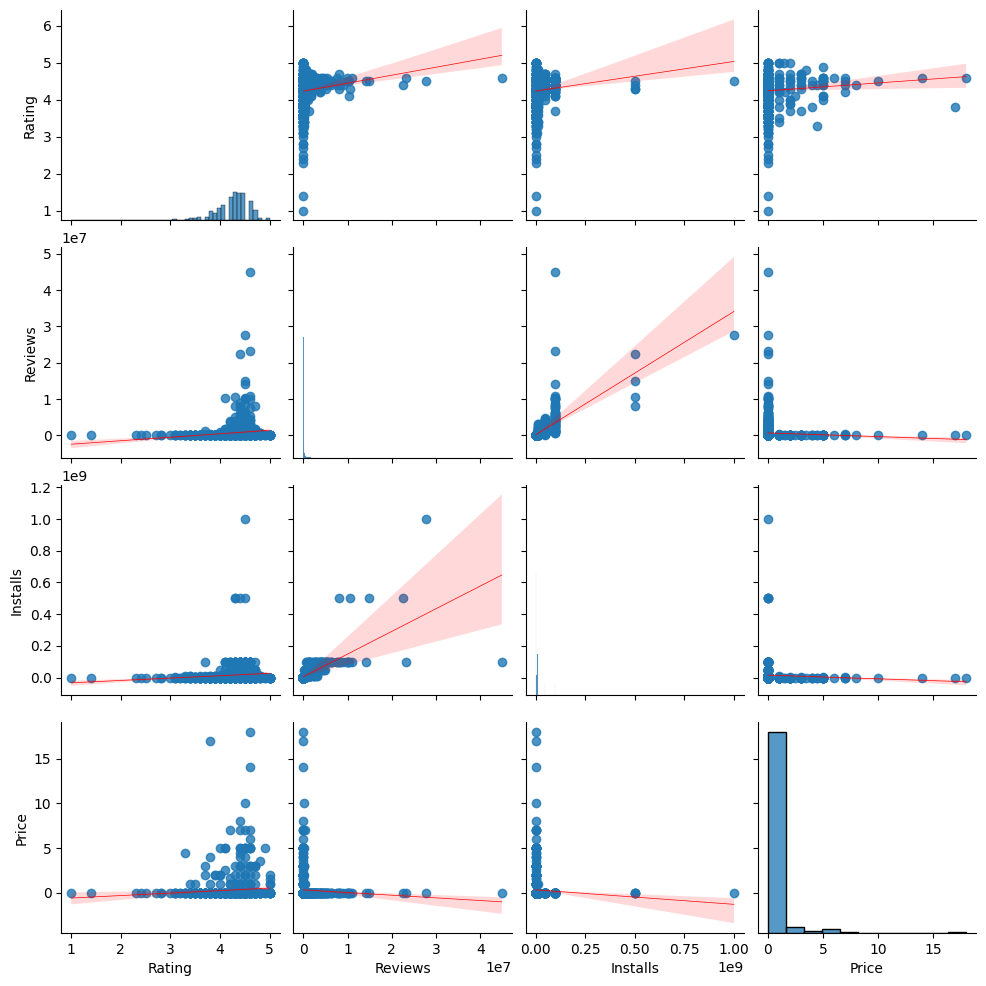

In [28]:
# matrix scatterplot with regression lines
plt.figure(figsize=(15,7))

matrix_scatter = sns.pairplot(data=gps_games,kind='reg',
                             plot_kws={'line_kws':{'color':'red','lw':0.5}}) #lw: linewidth

### Installs

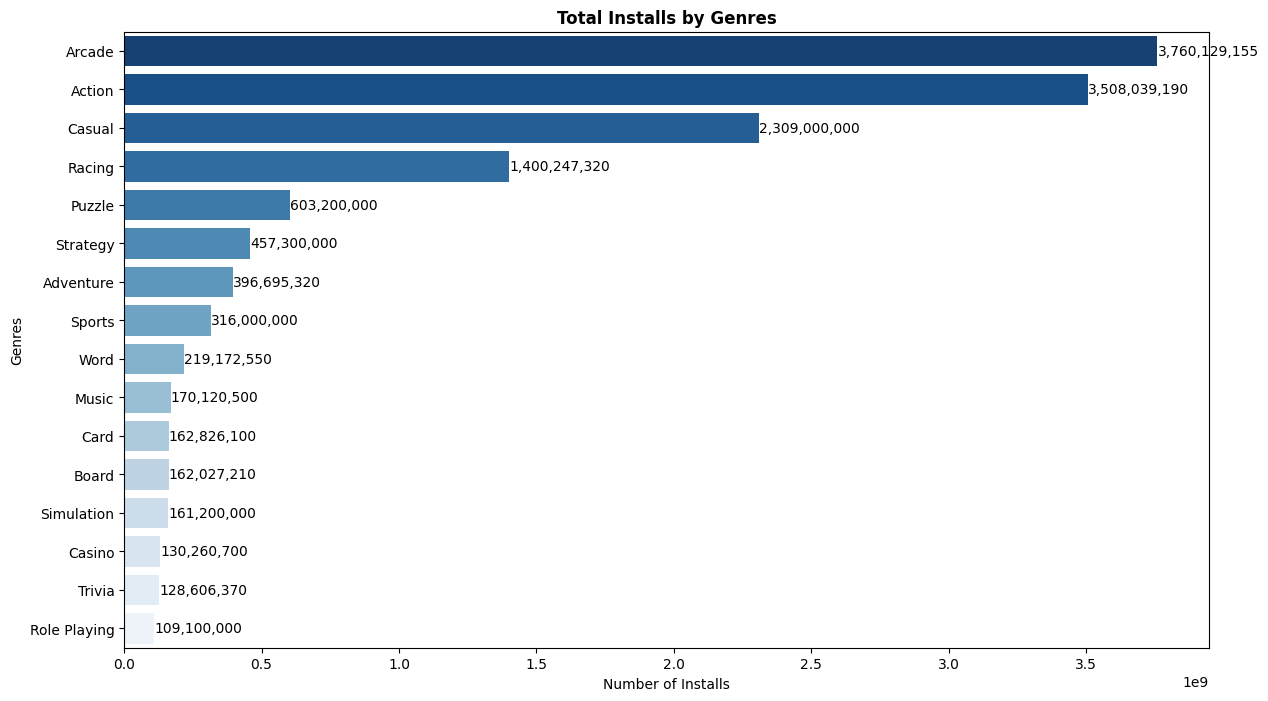

In [29]:
# Visualize the total installs by genres
installs_genres = gps_games.groupby('Genres').agg({'Installs':'sum', 'App':'nunique'}).reset_index().sort_values(by='Installs', ascending=False)
installs_genres['Installs'] = installs_genres['Installs']

plt.figure(figsize=(14,8))
sns.barplot(data=installs_genres, x='Installs', y='Genres', palette='Blues_r')
plt.title('Total Installs by Genres', weight='bold')
plt.xlabel('Number of Installs')
for i, v in enumerate(installs_genres['Installs']):
    plt.text(v+0.5, i, str('{:,.0f}'.format(v)), va='center',color='black', size=10)

plt.show()

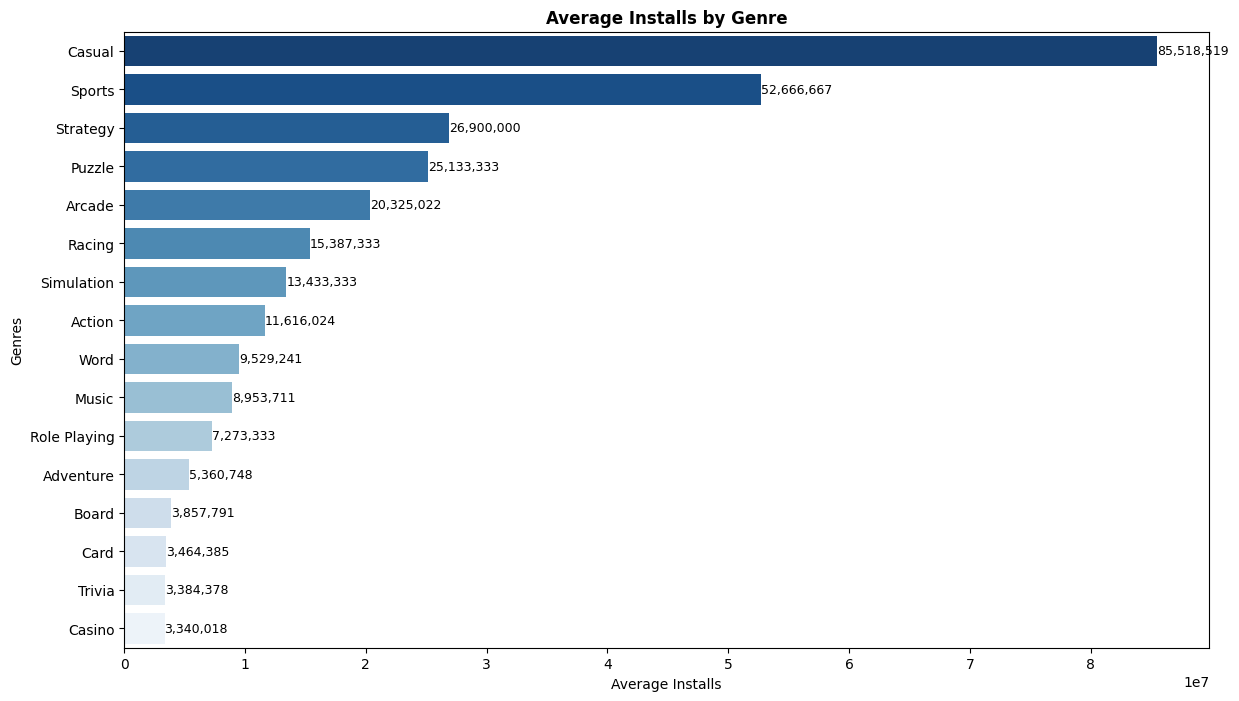

In [63]:
# Visualize the average number of installs by genres
installs_genres['Average Installs'] = installs_genres['Installs'] / installs_genres['App']
installs_genres = installs_genres.sort_values(by='Average Installs', ascending=False)

plt.figure(figsize=(14,8))
sns.barplot(data=installs_genres, x='Average Installs', y='Genres', palette='Blues_r')
for i, v in enumerate(installs_genres['Average Installs']):
    plt.text(v+0.5, i, str('{:,.0f}'.format(v)), va='center', color='black', size=9)
plt.title('Average Installs by Genre', weight='bold')
plt.show()

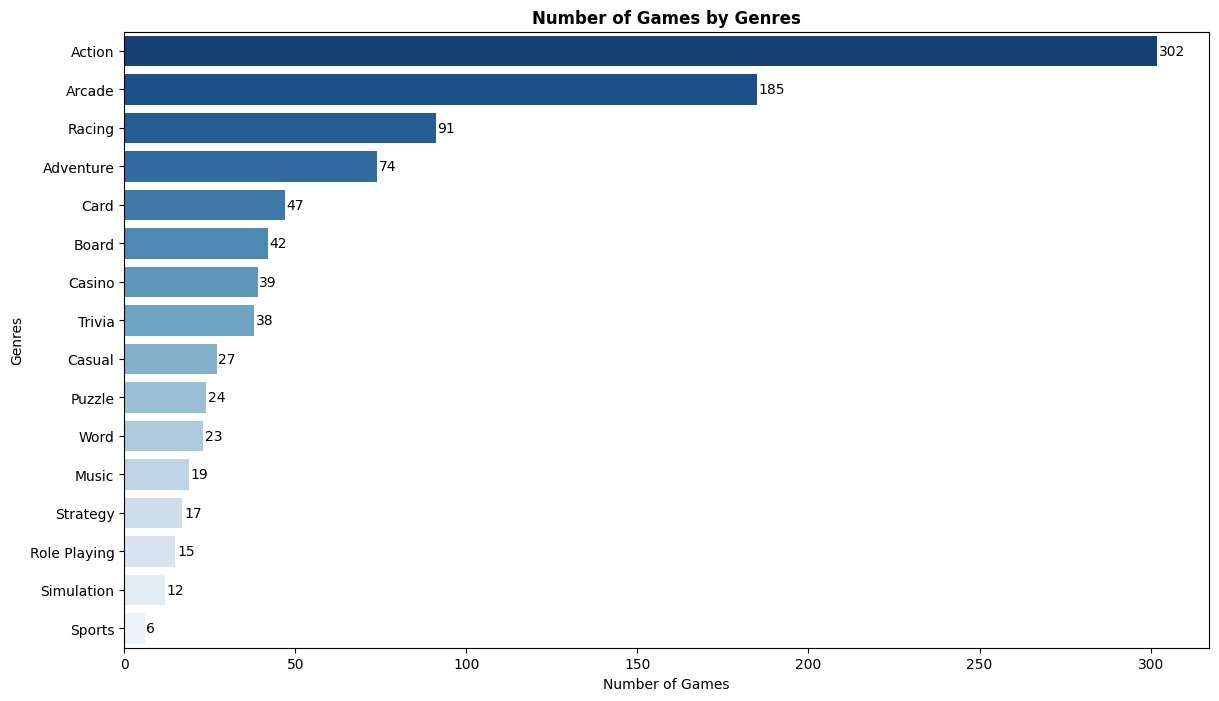

In [31]:
# Visualize the number of games by genres
installs_genres = installs_genres.sort_values(by='App', ascending=False)

plt.figure(figsize=(14,8))
ax = sns.barplot(data=installs_genres, x='App', y='Genres', palette='Blues_r')
plt.title('Number of Games by Genres', weight='bold')
plt.xlabel('Number of Games')

for i, v in enumerate(installs_genres['App']):
    ax.text(v + 0.5, i, str(v), color='black', va='center')

plt.show()

### Rating

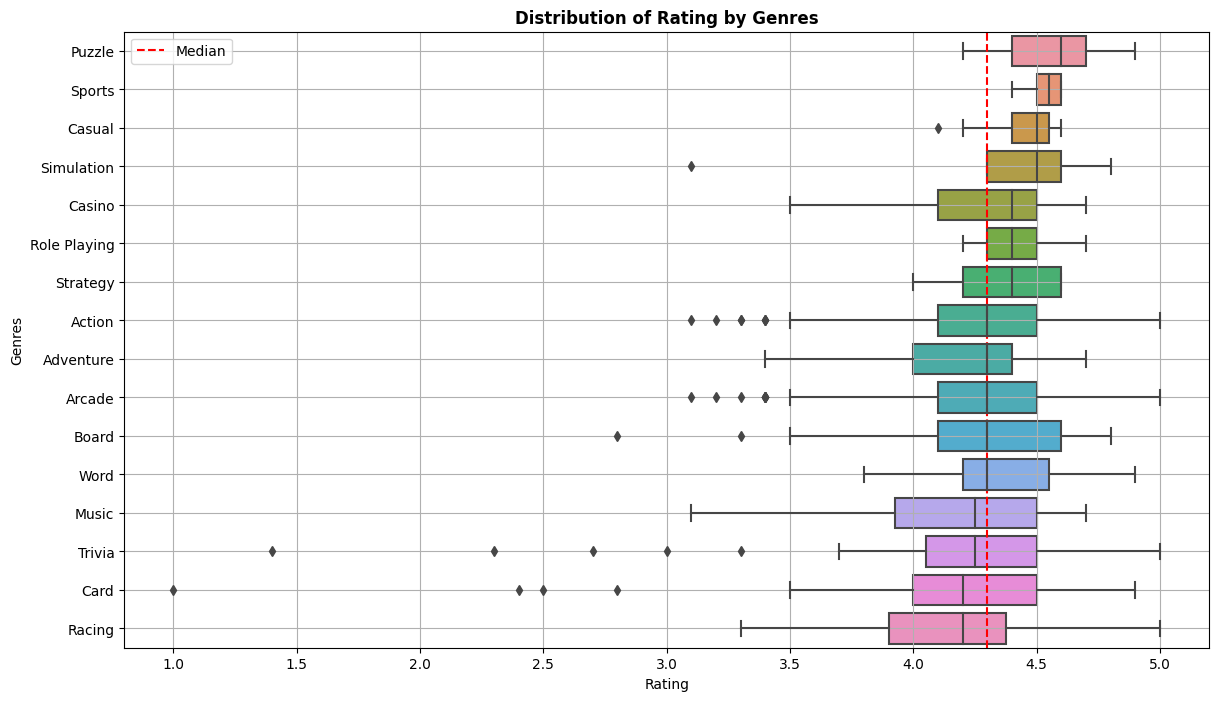

In [32]:
# Create a new dataset without null in rating
rating_genres = gps_games[gps_games['Rating'].notnull()]

# Sort the genres based on the median rating
sorted_genres = rating_genres.groupby('Genres')['Rating'].median().sort_values(ascending=False).index

# Create the boxplot with the sorted genres
plt.figure(figsize=(14,8))
sns.boxplot(data=rating_genres, y='Genres', x='Rating', order=sorted_genres)
plt.axvline(x=rating_genres['Rating'].median(), color='red', linestyle='--', label='Median')
plt.grid(True)
plt.title('Distribution of Rating by Genres', weight='bold')
plt.legend()
plt.show()

0.5817016787997953


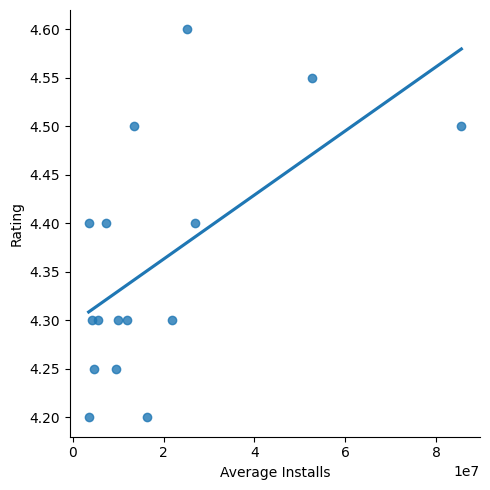

In [33]:
# Correlation: Rating & Average Installs
rating_installs = rating_genres.groupby('Genres').agg({'Rating':'median','Installs':'sum','App':'nunique'}).reset_index()
rating_installs['Average Installs'] = rating_installs['Installs']/rating_installs['App']
print(rating_installs['Rating'].corr(rating_installs['Average Installs']))

sns.lmplot(data=rating_installs, x='Average Installs', y='Rating', ci=None)
plt.show()

## **game_reviews**

### **% of Positive, Neutral and Negative Reviews**

In [38]:
prob_sentiment = game_reviews.groupby('Genres').agg({'App':'nunique', 'Translated_Review':'count'}).reset_index()
genres_pos_prob = (game_reviews[game_reviews['Sentiment']=='Positive'].groupby('Genres')['Sentiment'].count()*100/game_reviews.groupby('Genres')['Sentiment'].count()).to_dict()
genres_neg_prob = (game_reviews[game_reviews['Sentiment']=='Negative'].groupby('Genres')['Sentiment'].count()*100/game_reviews.groupby('Genres')['Sentiment'].count()).to_dict()
prob_sentiment['Positive (%)'] = prob_sentiment['Genres'].map(genres_pos_prob)
prob_sentiment['Negative (%)'] = prob_sentiment['Genres'].map(genres_neg_prob)
prob_sentiment['Neutral (%)'] = 100 - prob_sentiment['Positive (%)'] - prob_sentiment['Negative (%)']
prob_sentiment['Average Reviews'] = prob_sentiment['Translated_Review']/prob_sentiment['App']

genres_rating_dict = rating_genres.groupby('Genres')['Rating'].mean().to_dict()
prob_sentiment['Average Rating'] = prob_sentiment['Genres'].map(genres_rating_dict)

prob_sentiment

,Genres,App,Translated_Review,Positive (%),Negative (%),Neutral (%),Average Reviews,Average Rating
0,Action,24,2317,62.796720,32.110488,5.092792e+00,96.541667,4.246102
1,Adventure,2,55,72.727273,27.272727,-7.105427e-15,27.500000,4.183333
2,Arcade,14,1028,53.501946,43.482490,3.015564e+00,73.428571,4.273256
3,Board,5,183,78.688525,13.661202,7.650273e+00,36.600000,4.279487
4,Casual,16,1126,51.687389,41.740675,6.571936e+00,70.375000,4.444444
5,Puzzle,9,741,57.624831,37.381916,4.993252e+00,82.333333,4.533333
6,Racing,4,183,64.480874,30.601093,4.918033e+00,45.750000,4.150000
7,Role Playing,5,172,65.116279,31.395349,3.488372e+00,34.400000,4.406667
8,Simulation,5,343,64.723032,27.988338,7.288630e+00,68.600000,4.383333
9,Sports,2,222,47.747748,48.198198,4.054054e+00,111.000000,4.533333


<Figure size 1600x800 with 0 Axes>

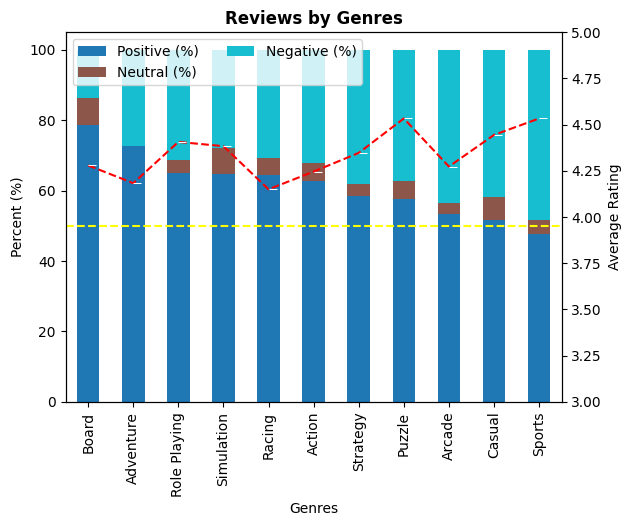

In [39]:
prob_sentiment_plot = prob_sentiment[['Genres','Positive (%)','Neutral (%)','Negative (%)']].sort_values(by='Positive (%)', ascending=False).set_index('Genres')

# Visualize the percentage of positive and negative reviews
plt.figure(figsize=(16,8))
ax1 = prob_sentiment_plot.plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Reviews by Genres', weight='bold')
plt.ylabel('Percent (%)')
plt.axhline(y=50, linestyle='--', color='yellow')
plt.legend(loc="upper left", ncol=2)

ax2 = ax1.twinx()

ax2 = sns.lineplot(data=prob_sentiment.sort_values(by='Positive (%)',ascending=False), x='Genres', y='Average Rating',color='red', linestyle='--', marker=True)
ax2.set_ylim(3,5)
ax2.set_ylabel('Average Rating')

plt.show()

# 4 -  Export Data

In [67]:
# # Mount to Google Sheets
# from google.colab import auth
# auth.authenticate_user()

# # Import neccessary libraries
# import gspread
# from gspread_dataframe import set_with_dataframe
# from google.auth import default
# creds, _ = default()

# # Authorize Google Sheets API
# gc = gspread.authorize(creds)

In [68]:
# def export_data_to_new_sheet(gsheet_key, worksheet_name, data):
#     """gsheet_key (str): ID of Google Sheet File. (Key is the part behind /d/ and before /edit
#                    For example: https://docs.google.com/spreadsheets/d/1WISuNUrWc-7BPO2s-pD3P3qqqgiLh0wRpvTNNtN21gA/edit?usp=sharing
#                    Key is 1WISuNUrWc-7BPO2s-pD3P3qqqgiLh0wRpvTNNtN21gA
#        worksheet_id (int): 0, 1, 2, ...
#        data (DataFrame): data to write
#     """
#     sh = gc.open_by_key(gsheet_key)

#     # To create a new worksheet with 5000 rows and 20 columns
#     worksheet = sh.add_worksheet(worksheet_name, 5000, 20)

#     # For writing to an existing worksheet
#     # worksheet = sh.get_worksheet(0) # --> to get the first worksheet

#     set_with_dataframe(worksheet, data)

In [69]:
# # Notice! Replace the key by your google sheet key

# # General
# export_data_to_new_sheet('1CupgqnFycAbgpZGdRl1ckTT9vJwU2Bhprz8jWEEG6rk','gps_games',gps_games)
# export_data_to_new_sheet('1CupgqnFycAbgpZGdRl1ckTT9vJwU2Bhprz8jWEEG6rk','game_reviews',game_reviews)

# # Installs
# export_data_to_new_sheet('1CupgqnFycAbgpZGdRl1ckTT9vJwU2Bhprz8jWEEG6rk','installs_genres',installs_genres)

# # Rating:
# export_data_to_new_sheet('1CupgqnFycAbgpZGdRl1ckTT9vJwU2Bhprz8jWEEG6rk','rating_genres',rating_genres)
# export_data_to_new_sheet('1CupgqnFycAbgpZGdRl1ckTT9vJwU2Bhprz8jWEEG6rk','rating_installs',rating_installs)

# # Review
# export_data_to_new_sheet('1CupgqnFycAbgpZGdRl1ckTT9vJwU2Bhprz8jWEEG6rk','prob_sentiment',prob_sentiment)